In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [4]:
BASE_DIR = os.getcwd()
DATASET_DIR = os.path.join(BASE_DIR, "dataset")

CLASS_NAMES = [
    "High_Motor_Coordination_Risk",
    "Mild_Motor_Coordination_Risk"
]

CLASS_DIRS = {
    class_name: os.path.join(DATASET_DIR, class_name)
    for class_name in CLASS_NAMES
}

print("Dataset path:", DATASET_DIR)
print("Classes found:", CLASS_DIRS)


Dataset path: c:\Projects\Dyspraxia\dataset
Classes found: {'High_Motor_Coordination_Risk': 'c:\\Projects\\Dyspraxia\\dataset\\High_Motor_Coordination_Risk', 'Mild_Motor_Coordination_Risk': 'c:\\Projects\\Dyspraxia\\dataset\\Mild_Motor_Coordination_Risk'}


In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

In [6]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    shear_range=0.15,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest"
)


train_gen = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)


Found 200 images belonging to 2 classes.


Found 49 images belonging to 2 classes.


In [7]:
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # transfer learning


In [8]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(2, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=output)


In [9]:
EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)


model.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,415,781 (16.84 MB)

 Trainable params: 363,650 (1.39 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [10]:
EPOCHS = 20

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 698ms/step - accuracy: 0.5450 - loss: 0.8516 - val_accuracy: 0.4286 - val_loss: 0.6927
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 502ms/step - accuracy: 0.5300 - loss: 0.8142 - val_accuracy: 0.5510 - val_loss: 0.6872
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 500ms/step - accuracy: 0.6400 - loss: 0.7108 - val_accuracy: 0.5510 - val_loss: 0.6873
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 495ms/step - accuracy: 0.5650 - loss: 0.7278 - val_accuracy: 0.4490 - val_loss: 0.6889
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 551ms/step - accuracy: 0.5800 - loss: 0.7710 - val_accuracy: 0.5918 - val_loss: 0.6841
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 625ms/step - accuracy: 0.5700 - loss: 0.8221 - val_accuracy: 0.5510 - val_loss: 0.6826
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 528ms/step - accuracy: 0.6350 - loss: 0.6955 - val_accuracy: 0.5510 - val_loss: 0.6785
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 522ms/step - accuracy: 0.6350 - loss: 0.7476 - val_accuracy: 0

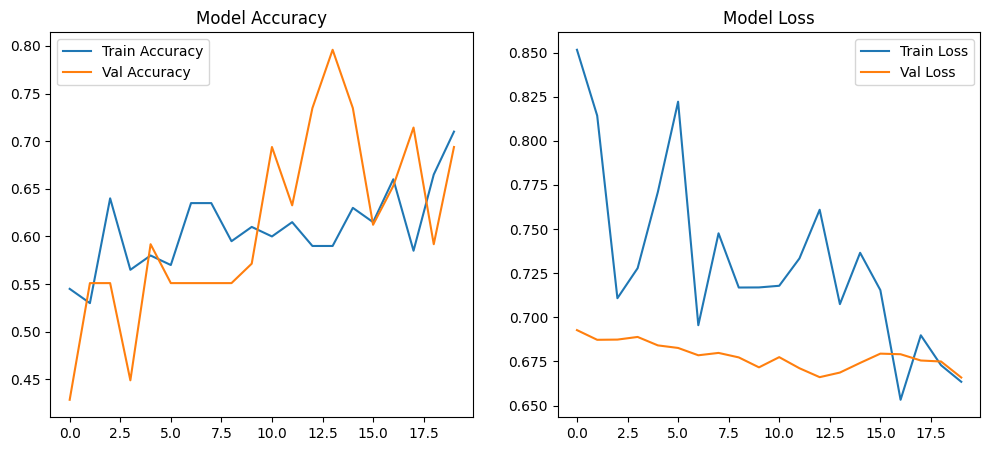

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')

plt.show()
